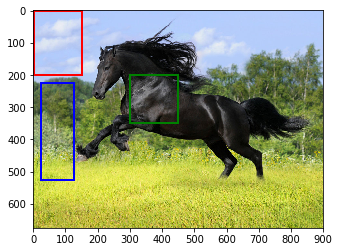

(1, 675, 900, 3) float32 (1, 675, 900, 3) float32


In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io 
import numpy as np
import tensorflow as tf
import matplotlib

img = io.imread('horse.jpg')
img = img/np.amax(img)

height,width,ch = img.shape

nclass = 3 # number of classes: sky, grass, horse

%matplotlib inline
fig,ax = plt.subplots(1)
ax.imshow(img)
# Create user labels
rect_sky = patches.Rectangle((1,1),150,200,linewidth=2,edgecolor='r',facecolor='none')
rect_grass = patches.Rectangle((25,225),100,300,linewidth=2,edgecolor='b',facecolor='none')
rect_horse = patches.Rectangle((300,200),150,150,linewidth=2,edgecolor='g',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect_sky)
ax.add_patch(rect_grass)
ax.add_patch(rect_horse)
plt.show()

partial_labels = np.zeros((1,height,width,nclass),dtype=np.float32)
partial_labels[0,0:200,0:150,0] = 1.0 
partial_labels[0,225:525,25:125,1] = 1.0 
partial_labels[0,200:350,300:450,2] = 1.0

img = np.reshape(img,(1,height,width,ch))
img = img.astype(np.float32)
print(img.shape,img.dtype,partial_labels.shape,partial_labels.dtype)


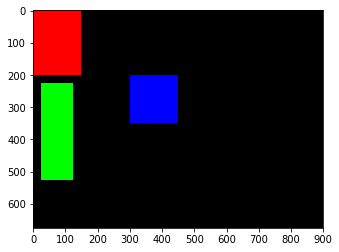

In [2]:
%matplotlib inline
fig,ax = plt.subplots(1)
img2 = np.reshape(partial_labels,(height,width,3))
ax.imshow(img2)


In [3]:
tf.reset_default_graph()

lr = tf.placeholder(tf.float32,shape=None,name="lr")
lam = tf.placeholder(tf.float32,shape=None,name="lam")

X = tf.placeholder(tf.float32,shape=(1,height,width,ch),name="X")
labels = tf.placeholder(tf.float32,shape=(1,height,width,nclass),name="partial_labels")

# weight initializer
he_init = tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32)

ksiz = 3 # 3-by-3 kernel throughout
nfilters=8
nfeatures=10

ac_fn = tf.nn.relu
# densenet type connections
hidden1 = tf.layers.conv2d(X,filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=ac_fn,kernel_initializer=he_init)
hidden2 = tf.layers.conv2d(tf.concat([X,hidden1],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=ac_fn,kernel_initializer=he_init)
hidden3 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=ac_fn,kernel_initializer=he_init)
hidden4 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=ac_fn,kernel_initializer=he_init)
hidden5 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3,hidden4],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=ac_fn,kernel_initializer=he_init)
hidden6 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3,hidden4,hidden5],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=ac_fn,kernel_initializer=he_init)
hidden7 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3,hidden4,hidden5,hidden6],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=ac_fn,kernel_initializer=he_init)
hidden8 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3,hidden4,hidden5,hidden6,hidden7],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=ac_fn,kernel_initializer=he_init)
hidden9 = tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3,hidden4,hidden5,hidden6,hidden7,hidden8],axis=3),filters=nfilters,kernel_size=(ksiz,ksiz),padding="same",activation=ac_fn,kernel_initializer=he_init)

# feature vectors
phi = tf.layers.conv2d(tf.concat([X,hidden1,hidden2,hidden3,hidden4,hidden5,hidden6,hidden7,hidden8,hidden9],axis=3),filters=nfeatures,kernel_size=(ksiz,ksiz),padding="same",activation=tf.tanh,kernel_initializer=he_init)
# logits
logits = tf.layers.conv2d(phi,filters=nclass,kernel_size=(ksiz,ksiz),padding="same",kernel_initializer=he_init)
# probabilities
prob  = tf.nn.softmax(logits,axis=3)

loss = tf.reduce_mean(tf.square(prob-labels)*labels)

# optimizer and training op
optimizer = tf.train.AdamOptimizer(lr)
training_op = optimizer.minimize(loss)

Instructions for updating:
Use the retry module or similar alternatives.


In [5]:
learning_rate = 1e-3
n_epochs = 100


config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
        if epoch%10==0:
            loss_val = sess.run(loss,feed_dict={X:img,labels:partial_labels})
            print("Epoch:",epoch,"Loss:",loss_val)
        sess.run(training_op, feed_dict={X:img,labels:partial_labels,lr:learning_rate})
    p_val = prob.eval(feed_dict={X:img})

Epoch: 0 Loss: 0.019767247
Epoch: 10 Loss: 0.008067383
Epoch: 20 Loss: 0.0038305428
Epoch: 30 Loss: 0.0010796386
Epoch: 40 Loss: 0.00028759052
Epoch: 50 Loss: 7.492152e-05
Epoch: 60 Loss: 3.0741718e-05
Epoch: 70 Loss: 1.8363822e-05
Epoch: 80 Loss: 1.3430086e-05
Epoch: 90 Loss: 1.0859675e-05


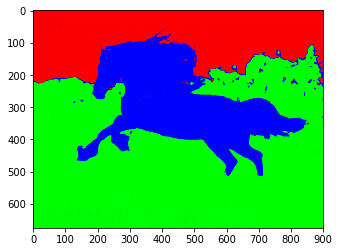

In [6]:
ClassIndicator = p_val.reshape((height,width,nclass))
%matplotlib inline
plt.imshow(ClassIndicator)


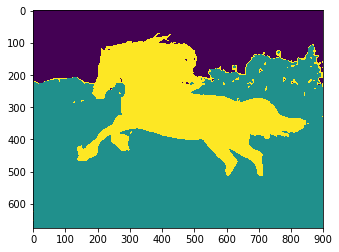

In [7]:
Seg = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        val   = -1
        label =-1
        for n in range(nclass):
            if ClassIndicator[i,j,n]>val:
                val = ClassIndicator[i,j,n]
                label = n
        Seg[i,j] = label

%matplotlib inline
plt.imshow(Seg)
